Dans le cadre de l'unité d'enseignement SR01, ce projet vise à développer un outil d'analyse de données pour l'application FITFAM. Cette application génère une quantité importante de données brutes (logs, entrées utilisateurs, ou mesures systèmes) qu'il est nécessaire de traiter pour en extraire de l'information pertinente.

Problématique : Comment automatiser la récupération et le traitement de ces données pour obtenir des indicateurs fiables sur le fonctionnement et l'utilisation de l'application ? L'objectif est de passer d'un fichier de données brut et illisible à une synthèse claire permettant de d'étudier la rétention de participants selon différents paramètres.

Extraction et lecture : Chargement des structures de données.

Traitement algorithmique : Filtrage, tri et calculs sur les données.

Restitution : Affichage formaté des résultats pour l'utilisateur.

Cette première étape consiste à initialiser les variables et à lire le fichier de données source (fichier texte, CSV ou binaire). Le code va ouvrir le flux de données, vérifier que le fichier existe et charger les informations en mémoire dans une structure adaptée (tableaux ou listes structurées). C'est ici que nous gérons également les éventuelles erreurs d'ouverture de fichier pour assurer la robustesse du programme.

In [8]:
from google.colab import drive
import os

# 1. Connecter le Drive
drive.mount('/content/drive')

# 2. Se déplacer dans le bon dossier (CHANGE LE CHEMIN ci-dessous !)
# Exemple : si ton projet est dans un dossier "SR01_Projet"
os.chdir('/content/drive/MyDrive/SR01-FITFAM')

# 3. Vérifier qu'on est au bon endroit
print("Fichiers disponibles ici :", os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fichiers disponibles ici : ['SR01.gdoc', 'fitfam-json.zip', 'donnees', 'data_loader.pyc', '.ipynb_checkpoints', '__pycache__', 'data_loader.py', 'reseau_sports_corrige.gexf', 'reseau_sports_fleches.gexf', 'reseau_once_off_focus.gexf', 'julesr_river.ipynb', 'reseau_conversion_reelle.gexf', 'comparaison_annees_once_off.gexf']


In [9]:
# @title
from data_loader import FitFamDataLoader

# Initialisation du chargeur de données
loader = FitFamDataLoader('./donnees')

# Récupération des données JSON
df = loader.get_unified_data()

# Affichage d'un échantillon
print(f"Chargement terminé. Taille du dataset : {df.shape}")
print(df.head())


--- 1. CHARGEMENT DES FICHIERS ---
⚠️ event_user.json: AUCUNE colonne ID trouvée. Colonnes dispos : ['event_id', 'user_id', 'checked_in', 'is_leader', 'created_at']...
⚠️ category_event.json: AUCUNE colonne ID trouvée. Colonnes dispos : ['category_id', 'event_id']...

--- 2. FUSION DES DONNÉES ---

--- 3. CRÉATION DU DATASET FINAL ---
🛑 ÉCHEC FUSION: La colonne 'user_id' manque dans la table de GAUCHE.
✅ TERMINÉ ! Dataset généré avec 405861 lignes.
Chargement terminé. Taille du dataset : (405861, 52)
   event_id_x  user_id_x  checked_in  is_leader         created_at_x  \
0           1          1         NaN          0  2018-08-06 11:10:14   
1           1          3         NaN          0  2018-08-06 21:42:05   
2           3          1         1.0          0  2018-08-12 12:12:50   
3           3          3         0.0          0  2018-08-07 14:39:25   
4           3          4         1.0          0  2018-08-07 14:39:54   

          updated_at_x  id user_id_y  recurring_group_id  lo

Une fois les données chargées, nous passons au cœur du traitement. Ce bloc de code applique la logique métier définie dans le cahier des charges. Il parcourt les données pour effectuer une mise en relation entre les différents id cela permet dans ce cas de vérifier quel atelier conserve le plus d'utilisateur
. C'est dans cette partie que l'algorithme transforme la donnée brute en donnée utile en appliquant les filtres nécessaires à l'analyse.

In [ ]:
import pandas as pd
import numpy as np

# Data Cleaning
df = df.rename(columns={'user_id_x': 'user_id', 'event_id_x': 'event_id', 'start_time_x': 'start_time'})
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')

# Feature Engineering: User Aggregation
df = df.sort_values(['user_id', 'start_time'])

user_stats = df.groupby('user_id').agg({
    'start_time': ['min', 'max'],
    'event_id': 'count',
    'category_name': 'first',
    'city_name': 'first'
}).reset_index()

user_stats.columns = ['user_id', 'first_workout', 'last_workout', 'total_sessions', 'first_category', 'city']

# Target Definition (Retention M3)
user_stats['tenure_days'] = (user_stats['last_workout'] - user_stats['first_workout']).dt.days

# Filter cohort (users active for at least 90 days)
analysis_date = df['start_time'].max()
user_stats['days_since_signup'] = (analysis_date - user_stats['first_workout']).dt.days

valid_users = user_stats[user_stats['days_since_signup'] >= 90].copy()
valid_users['is_retained_m3'] = valid_users['tenure_days'] >= 90

print(f"Final Dataset Shape: {valid_users.shape}")
print(valid_users['is_retained_m3'].value_counts(normalize=True))

Final Dataset Shape: (21016, 9)
is_retained_m3
False    0.652836
True     0.347164
Name: proportion, dtype: float64


Cette dernière partie technique se concentre sur la présentation des résultats. Maintenant que les calculs sont terminés, le code va formater la sortie pour qu'elle soit lisible par l'utilisateur final. Il génère un rapport dans la console affichant les métriques clés, comme l'atelier ayant le plus d'utilisateurs réguliers, permettant une lecture directe de l'état de l'application.


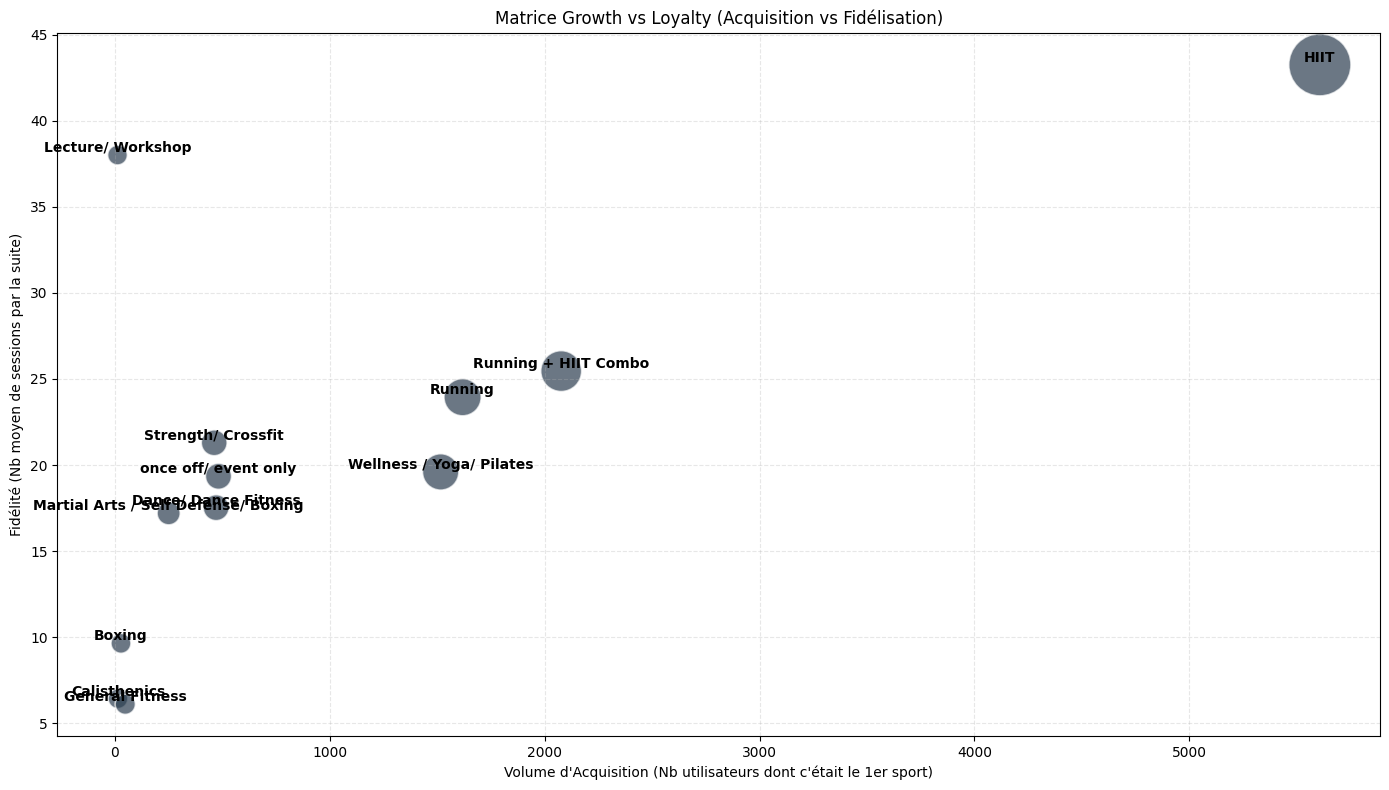

Top Catégories par Fidélité :
                               Category  Avg_Sessions_Per_User  \
7                                  HIIT              43.244829   
9                     Lecture/ Workshop              38.000000   
12                 Running + HIIT Combo              25.454983   
11                              Running              23.938195   
13                   Strength/ Crossfit              21.290043   
16             Wellness / Yoga/ Pilates              19.598945   
17                 once off/ event only              19.344398   
3                  Dance/ Dance Fitness              17.522293   
10  Martial Arts / Self Defense/ Boxing              17.196000   
0                                Boxing               9.642857   

    New_Users_Volume  
7               5608  
9                 12  
12              2077  
11              1618  
13               462  
16              1516  
17               482  
3                471  
10               250  
0            

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- ETAPE 1 : PRÉPARATION (Ce qui manquait) ---
# On s'assure que les dates sont bien au format date
if 'created_at_x' in df.columns:
    df['created_at_x'] = pd.to_datetime(df['created_at_x'])

# On trie pour être sûr d'avoir l'ordre chronologique
df = df.sort_values(['user_id_x', 'created_at_x'])

# ON CRÉE LE TABLEAU 'valid_users'
# On groupe par utilisateur pour savoir quel a été leur PREMIER sport et combien de fois ils sont venus
valid_users = df.groupby('user_id_x').agg(
    first_category=('next_sport', 'first'),  # Le tout premier sport pratiqué
    total_sessions=('id', 'count')           # Nombre total de sessions
).reset_index()

# Renommer user_id_x en user_id pour que ça colle avec ton code de graphique
valid_users.rename(columns={'user_id_x': 'user_id'}, inplace=True)

# --- ETAPE 2 : AGRÉGATION PAR CATÉGORIE ---
cat_stats = valid_users.groupby('first_category').agg({
    'user_id': 'count',          # Combien de nouveaux utilisateurs acquis ?
    'total_sessions': 'mean'     # Moyenne de fidélité
}).reset_index()

cat_stats.columns = ['Category', 'New_Users_Volume', 'Avg_Sessions_Per_User']

# --- ETAPE 3 : FILTRE ET VISUALISATION ---
# ATTENTION : J'ai mis > 10 au lieu de > 50 pour être sûr que tu voies quelque chose si ton dataset est petit.
# Tu peux remettre 50 si tu as beaucoup de données.
cat_stats_filtered = cat_stats[cat_stats['New_Users_Volume'] > 10].sort_values('Avg_Sessions_Per_User', ascending=False)

plt.figure(figsize=(14, 8))

# Le graphique
sns.scatterplot(
    data=cat_stats_filtered,
    x='New_Users_Volume',
    y='Avg_Sessions_Per_User',
    size='New_Users_Volume',
    sizes=(200, 2000), # Bulles un peu plus grosses
    alpha=0.7,
    color='#2c3e50',
    legend=False
)

# Les textes (Annotations)
for i in range(len(cat_stats_filtered)):
    plt.text(
        x=cat_stats_filtered.New_Users_Volume.iloc[i],
        y=cat_stats_filtered.Avg_Sessions_Per_User.iloc[i],
        s=cat_stats_filtered.Category.iloc[i],
        size='medium',
        color='black',
        weight='bold',
        ha='center', # Centré horizontalement
        va='bottom'  # Texte posé sur le point
    )

plt.title('Matrice Growth vs Loyalty (Acquisition vs Fidélisation)')
plt.xlabel("Volume d'Acquisition (Nb utilisateurs dont c'était le 1er sport)")
plt.ylabel("Fidélité (Nb moyen de sessions par la suite)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top Catégories par Fidélité :")
print(cat_stats_filtered[['Category', 'Avg_Sessions_Per_User', 'New_Users_Volume']].head(10))

D'après l'étude de Heinrich et al. (2014) sur le CrossFit, on voit que les programmes à haute intensité génèrent souvent une meilleure rétention que les entraînements classiques, principalement grâce au sentiment d'appartenance à une communauté.

Concernant la formation de l'habitude, les travaux de Lally et al. (2010) montrent qu'il faut en moyenne 66 jours pour qu'une activité sportive devienne automatique, ce qui explique pourquoi on risque de voir beaucoup d'abandons les deux premiers mois.

Enfin, une revue systématique de Eime et al. (2013) souligne que les sports avec une dimension sociale ou d'équipe ont des taux de participation bien plus stables que les sports individuels pratiqués seuls.

PARTIE 2 : Analyse des données via un graphe bibliothèque network X


In [ ]:
# @title
import pandas as pd

# On suppose que 'df' est déjà chargé et trié
# Si tu as besoin de re-trier par sécurité :
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df = df.sort_values(by=['user_id_x', 'start_time'])

print("🔄 Calcul des transitions (sans répétitions)...")

# 1. DÉTECTION
df['next_sport'] = df.groupby('user_id_x')['category_name'].shift(-1)
transitions = df.dropna(subset=['next_sport'])

# 2. FILTRAGE (C'est ici qu'on enlève HIIT -> HIIT)
# On ne garde que les lignes où le sport actuel est DIFFÉRENT du sport suivant
transitions = transitions[transitions['category_name'] != transitions['next_sport']]

# 3. COMPTAGE
flux = transitions.groupby(['category_name', 'next_sport']).size().reset_index(name='weight')
flux_trie = flux.sort_values(by='weight', ascending=False)

# 4. AFFICHAGE
print(f"\n📊 RÉSULTAT FILTRÉ : {len(flux_trie)} types de transitions (changements de sport) identifiées.\n")
print("-" * 60)
print("TOP 10 DES PASSERELLES ENTRE SPORTS :")
print("-" * 60)

for index, row in flux_trie.head(10).iterrows():
    source = row['category_name']
    cible = row['next_sport']
    nombre = row['weight']
    print(f" -> {nombre} fois : De [{source}] vers [{cible}]")

print("-" * 60)

🔄 Calcul des transitions (sans répétitions)...

📊 RÉSULTAT FILTRÉ : 238 types de transitions (changements de sport) identifiées.

------------------------------------------------------------
TOP 10 DES PASSERELLES ENTRE SPORTS :
------------------------------------------------------------
 -> 16693 fois : De [HIIT] vers [Running]
 -> 16168 fois : De [Running] vers [HIIT]
 -> 14568 fois : De [HIIT] vers [Wellness / Yoga/ Pilates]
 -> 14387 fois : De [Wellness / Yoga/ Pilates] vers [HIIT]
 -> 10696 fois : De [Running + HIIT Combo] vers [HIIT]
 -> 10117 fois : De [HIIT] vers [Running + HIIT Combo]
 -> 6800 fois : De [HIIT] vers [Strength/ Crossfit]
 -> 6619 fois : De [Strength/ Crossfit] vers [HIIT]
 -> 4338 fois : De [HIIT] vers [once off/ event only]
 -> 4245 fois : De [Running] vers [Running + HIIT Combo]
------------------------------------------------------------


In [ ]:
# @title
import pandas as pd
import networkx as nx
from itertools import combinations

# --- 1. NETTOYAGE DES COLONNES (Pour éviter le KeyError) ---
# On enlève les espaces vides au début et à la fin des noms de colonnes
df.columns = df.columns.str.strip()

print("Colonnes disponibles :", df.columns.tolist())

# Vérification de sécurité
if 'next_sport' not in df.columns:
    print("❌ ERREUR CRITIQUE : La colonne 'next_sport' est toujours introuvable.")
    print("Vérifie l'orthographe exacte dans la liste ci-dessus.")
else:
    print("✅ Colonne 'next_sport' trouvée !")

    # --- 2. CONFIGURATION ---
    target_categories = [
        "HIIT", "Strength/ Crossfit", "Running", "Running + HIIT Combo",
        "once off/ event only", "Dance/ Dance Fitness",
        "Wellness / Yoga/ Pilates", "Martial Arts / Self Defense/ Boxing",
        "General Fitness"
    ]

    # --- 3. PRÉPARATION DES DONNÉES ---
    # On ne garde que les lignes avec tes catégories cibles
    df_clean = df[df['next_sport'].isin(target_categories)].copy()

    # IMPORTANT : On regroupe par UTILISATEUR ('user_id_x').
    # Cela crée une liste de sports pour chaque personne.
    # Si User1 a fait HIIT et Running, on aura ['HIIT', 'Running']
    print("Regroupement par utilisateur en cours...")
    user_sports = df_clean.groupby('user_id_x')['next_sport'].unique()

    # --- 4. CRÉATION DU GRAPHE ---
    G = nx.Graph()

    # Ajouter les noeuds
    for cat in target_categories:
        G.add_node(cat, label=cat)

    print(f"Calcul des liens sur {len(user_sports)} utilisateurs...")

    # Ajouter les liens (Arêtes)
    for sports_list in user_sports:
        # Il faut que l'utilisateur ait fait au moins 2 sports différents pour créer un lien
        if len(sports_list) > 1:
            for u, v in combinations(sports_list, 2):
                if G.has_edge(u, v):
                    G[u][v]['weight'] += 1
                else:
                    G.add_edge(u, v, weight=1)

    # --- 5. EXPORT ---
    output_file = "reseau_sports_corrige.gexf"
    nx.write_gexf(G, output_file)
    print(f"🎉 Succès ! Le fichier '{output_file}' a été généré.")

Colonnes disponibles : ['event_id_x', 'user_id_x', 'checked_in', 'is_leader', 'created_at_x', 'updated_at_x', 'id', 'user_id_y', 'recurring_group_id', 'location_id', 'name', 'description', 'to_bring', 'start_time', 'end_time', 'registration_start', 'registration_end', 'max_attendees', 'frequency_details', 'contact_name', 'contact_wechat', 'is_aqi_dependent', 'is_featured', 'members_only', 'status', 'created_at_y', 'updated_at_y', 'name_en', 'event_id_y', 'category_name', 'id_loc', 'city_id', 'name_loc', 'description_loc', 'instructions', 'contact_name_loc', 'contact_phone', 'short_address', 'full_address', 'latitude', 'longitude', 'status_loc', 'created_at_loc', 'updated_at_loc', 'location_name', 'id_city', 'province_id', 'image', 'city_name', 'slug', 'created_at_city', 'updated_at_city', 'next_sport']
✅ Colonne 'next_sport' trouvée !
Regroupement par utilisateur en cours...
Calcul des liens sur 12572 utilisateurs...
🎉 Succès ! Le fichier 'reseau_sports_corrige.gexf' a été généré.


In [ ]:
# @title
import pandas as pd
import networkx as nx
from itertools import combinations

# ... (TES ÉTAPES DE NETTOYAGE ET CHARGEMENT DE DONNÉES RESTENT PAREILLES) ...
# On reprend juste après le filtrage des utilisateurs

# --- CHANGEMENT 1 : On utilise DiGraph (Directed Graph) ---
G = nx.DiGraph()

# Ajouter les noeuds
for cat in target_categories:
    G.add_node(cat, label=cat)

print(f"Calcul des liens orientés...")

# Ajouter les liens (Arêtes)
for sports_list in user_sports:
    if len(sports_list) > 1:
        # combinations donne des paires (A, B).
        # Comme tes données n'ont pas d'ordre chronologique strict ici (c'est le même user),
        # on va créer une DOUBLE FLÈCHE pour montrer que le lien est fort dans les deux sens.
        for u, v in combinations(sports_list, 2):

            # Flèche de u vers v
            if G.has_edge(u, v):
                G[u][v]['weight'] += 1
            else:
                G.add_edge(u, v, weight=1)

            # --- CHANGEMENT 2 : On ajoute la flèche retour (v vers u) ---
            # Pour avoir des flèches des deux côtés (<-->)
            if G.has_edge(v, u):
                G[v][u]['weight'] += 1
            else:
                G.add_edge(v, u, weight=1)

# --- EXPORT ---
output_file = "reseau_sports_fleches.gexf"
nx.write_gexf(G, output_file)
print(f"🏹 C'est prêt ! Ouvre '{output_file}' pour voir les flèches.")

Calcul des liens orientés...
🏹 C'est prêt ! Ouvre 'reseau_sports_fleches.gexf' pour voir les flèches.


In [ ]:
print(df.columns)
print("---")
print(df.head(1)) # Affiche la première ligne pour voir à quoi ça ressemble

Index(['event_id_x', 'user_id_x', 'checked_in', 'is_leader', 'created_at_x',
       'updated_at_x', 'id', 'user_id_y', 'recurring_group_id', 'location_id',
       'name', 'description', 'to_bring', 'start_time', 'end_time',
       'registration_start', 'registration_end', 'max_attendees',
       'frequency_details', 'contact_name', 'contact_wechat',
       'is_aqi_dependent', 'is_featured', 'members_only', 'status',
       'created_at_y', 'updated_at_y', 'name_en', 'event_id_y',
       'category_name', 'id_loc', 'city_id', 'name_loc', 'description_loc',
       'instructions', 'contact_name_loc', 'contact_phone', 'short_address',
       'full_address', 'latitude', 'longitude', 'status_loc', 'created_at_loc',
       'updated_at_loc', 'location_name', 'id_city', 'province_id', 'image',
       'city_name', 'slug', 'created_at_city', 'updated_at_city',
       'next_sport'],
      dtype='object')
---
   event_id_x  user_id_x  checked_in  is_leader         created_at_x  \
5           4       

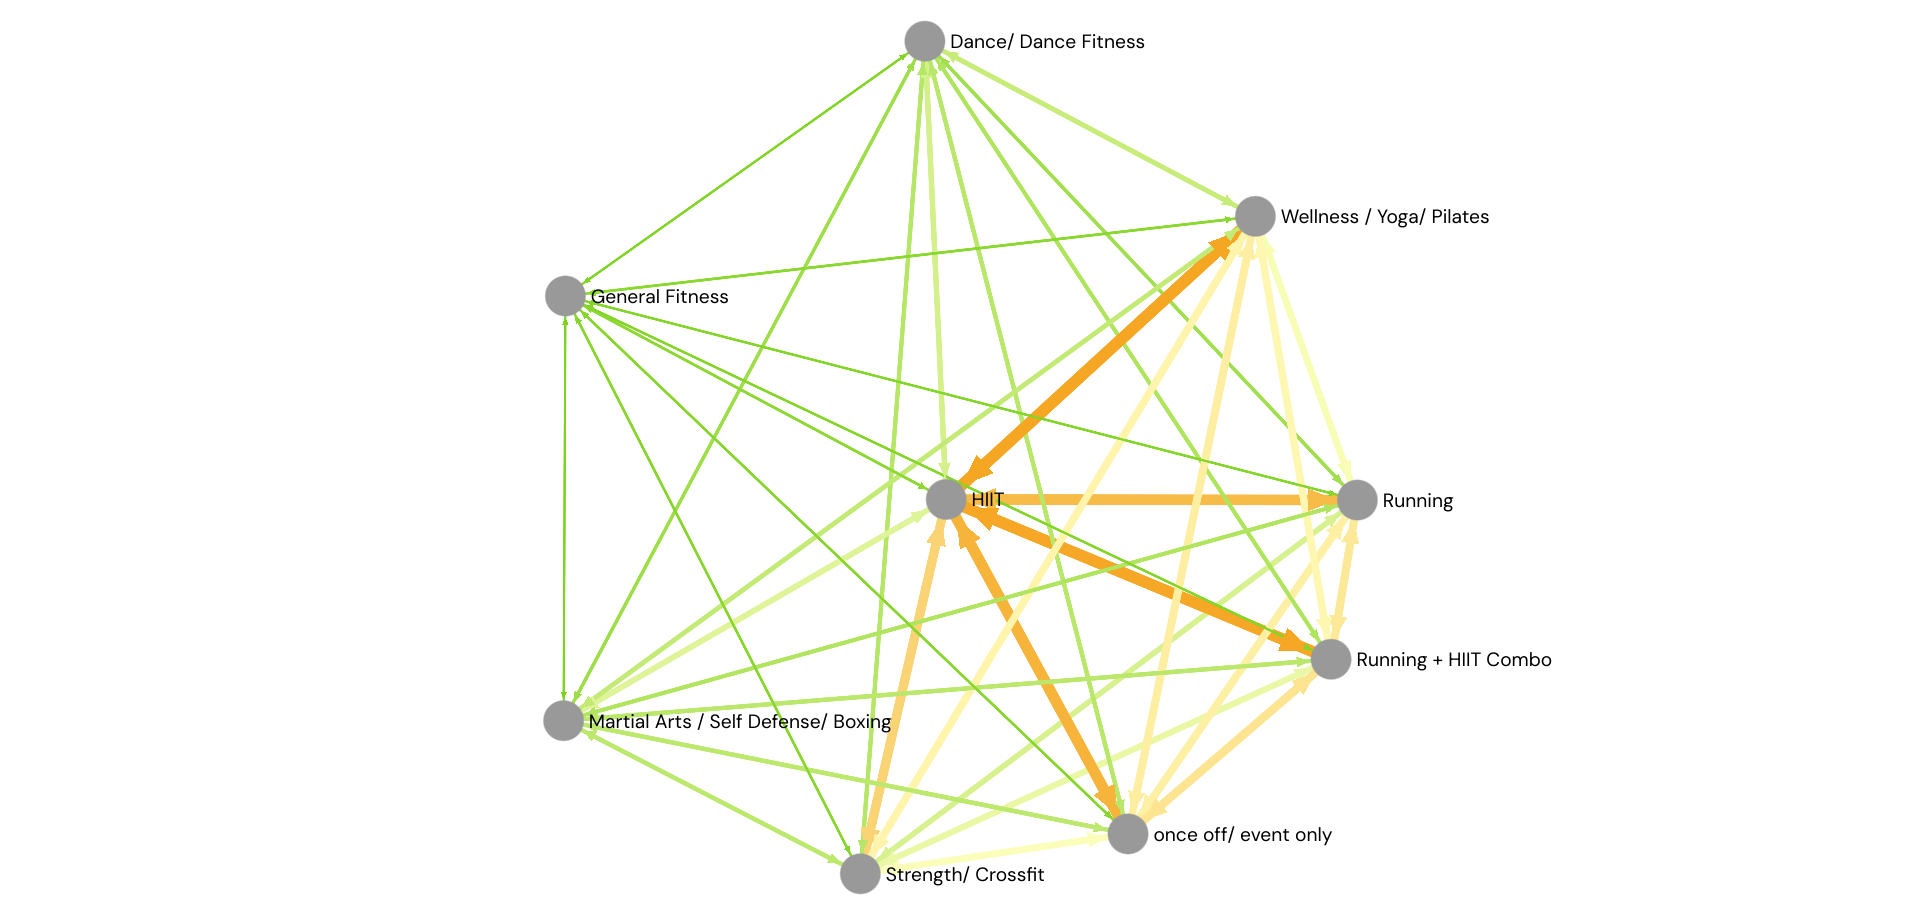

In [6]:
# @title
import pandas as pd
import networkx as nx

# --- 1. CONFIGURATION (Adaptée à tes colonnes actuelles) ---
# D'après ta liste, la colonne sport est 'category_name'
nom_colonne = 'category_name'
date_colonne = 'start_time'

source_node = "once off/ event only" # Vérifie bien que ce nom est écrit exactement comme dans tes données
target_categories = [
    "HIIT", "Strength/ Crossfit", "Running", "Running + HIIT Combo",
    "Dance/ Dance Fitness", "Wellness / Yoga/ Pilates",
    "Martial Arts / Self Defense/ Boxing", "General Fitness"
]

# --- 2. VÉRIFICATION DES VALEURS ---
# On vérifie si les catégories existent bien dans cette colonne
print(f"Exemples de valeurs dans '{nom_colonne}': {df[nom_colonne].unique()[:5]}")

all_cats = target_categories + [source_node]

# --- 3. PRÉPARATION CHRONOLOGIQUE ---
print("Tri des données par date...")

# Conversion de la date
df[date_colonne] = pd.to_datetime(df[date_colonne])

# Filtrage : On ne garde que les lignes qui contiennent nos catégories cibles
df_clean = df[df[nom_colonne].isin(all_cats)].copy()

# TRI CRUCIAL : Par User, puis par Date
df_clean = df_clean.sort_values(by=['user_id_x', date_colonne])

# --- 4. ANALYSE DU "TUNNEL DE DÉCOUVERTE" ---
print("Analyse des parcours utilisateurs...")

G = nx.DiGraph()
G.add_node(source_node, label=source_node, type="Source")
for cat in target_categories:
    G.add_node(cat, label=cat, type="Target")

# On groupe par user
grouped = df_clean.groupby('user_id_x')

liens_trouves = 0

for user, data in grouped:
    timeline = data[nom_colonne].tolist()

    # Mémoire de l'utilisateur (Ce qu'il a déjà fait AVANT)
    sports_connus = set()

    for i in range(len(timeline) - 1):
        current_sport = timeline[i]
        next_sport = timeline[i+1]

        # On ajoute le sport actuel à son historique personnel
        sports_connus.add(current_sport)

        # Si on est sur un événement "Once Off"
        if current_sport == source_node:
            # Et que le suivant est un sport cible (différent de once off)
            if next_sport in target_categories and next_sport != source_node:

                # LA CONDITION CLÉ : Est-ce qu'il a déjà fait ce sport AVANT ?
                if next_sport not in sports_connus:
                    # C'est une VRAIE découverte (Conversion)
                    liens_trouves += 1
                    if G.has_edge(source_node, next_sport):
                        G[source_node][next_sport]['weight'] += 1
                    else:
                        G.add_edge(source_node, next_sport, weight=1)

# --- 5. EXPORT ---
print(f"Nombre de conversions trouvées : {liens_trouves}")

if liens_trouves == 0:
    print("⚠️ ATTENTION : 0 liens trouvés. Vérifie que le nom 'once off/ event only' est écrit EXACTEMENT pareil dans ta colonne 'category_name'.")
else:
    output_file = "reseau_conversion_reelle.gexf"
    nx.write_gexf(G, output_file)
    print(f"✅ SUCCÈS ! Fichier '{output_file}' généré.")

Exemples de valeurs dans 'category_name': ['{{ Type }}' 'HIIT' 'Running' 'Running + HIIT Combo' 'Strength/ Crossfit']
Tri des données par date...
Analyse des parcours utilisateurs...
Nombre de conversions trouvées : 1227
✅ SUCCÈS ! Fichier 'reseau_conversion_reelle.gexf' généré.


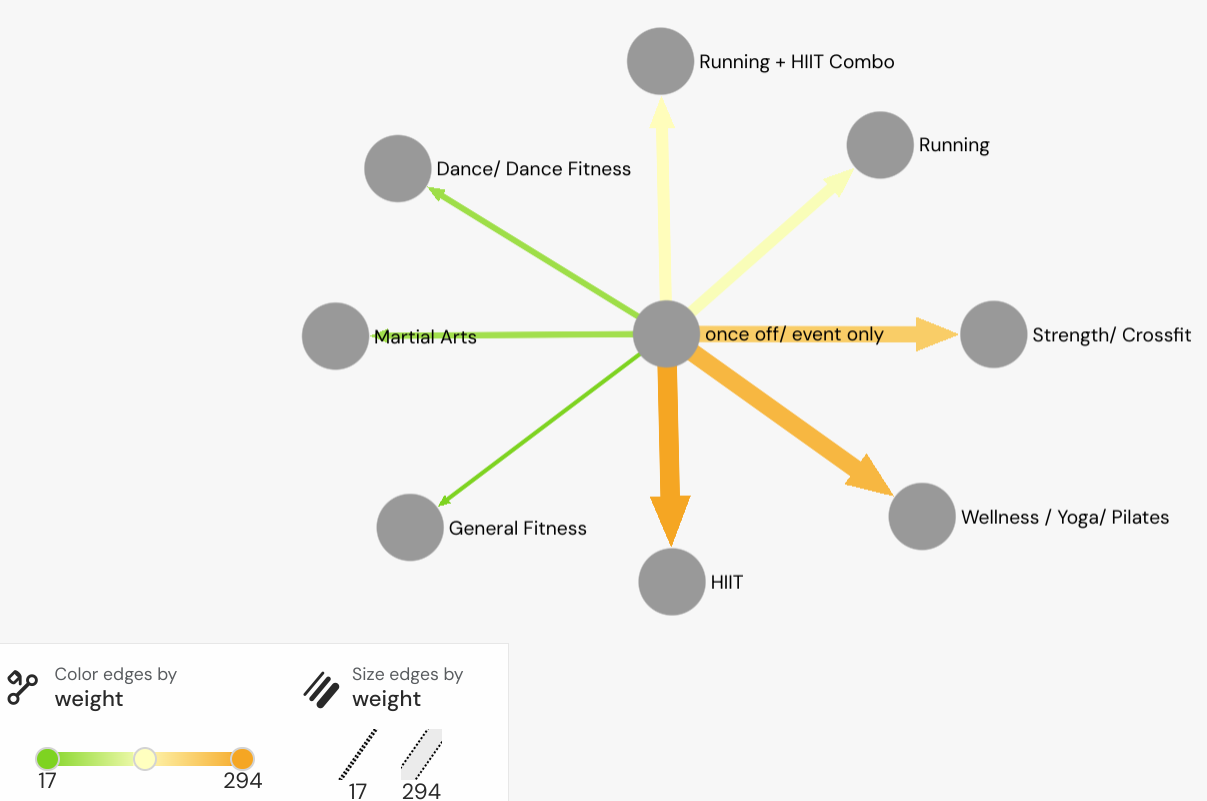


Ce graphe isole les nouvelles vocations. Il montre vers quels sports se dirigent les participants d'événements uniques (Once Off) lorsqu'ils testent une discipline inédite pour eux. C'est une mesure pure de l'efficacité de ces événements comme canal d'acquisition.

In [10]:
# @title
import pandas as pd
import networkx as nx

# --- 1. CONFIGURATION ---
nom_colonne = 'category_name'
date_colonne = 'start_time'
source_node_raw = "once off/ event only"

target_categories = [
    "HIIT", "Strength/ Crossfit", "Running", "Running + HIIT Combo",
    "Dance/ Dance Fitness", "Wellness / Yoga/ Pilates",
    "Martial Arts / Self Defense/ Boxing", "General Fitness"
]

annees_cible = [2023, 2024, 2025]

# --- 2. PRÉPARATION ---
print("--- PRÉPARATION ---")
df.columns = df.columns.str.strip()
df[date_colonne] = pd.to_datetime(df[date_colonne])

# Petit audit des données AVANT filtrage complexe
print("📊 Audit des données brutes (lignes contenant 'Once Off') :")
for annee in annees_cible:
    count = df[
        (df[nom_colonne] == source_node_raw) &
        (df[date_colonne].dt.year == annee)
    ].shape[0]
    print(f"  - Année {annee} : {count} événements '{source_node_raw}' trouvés.")

# Filtrage pour l'algo
all_cats = target_categories + [source_node_raw]
df_clean = df[df[nom_colonne].isin(all_cats)].copy()
df_clean = df_clean.sort_values(by=['user_id_x', date_colonne])

# --- 3. CRÉATION DU GRAPHE ---
G = nx.DiGraph()

# Compteurs pour débugger la conversion
stats_conversions = {y: 0 for y in annees_cible}

grouped = df_clean.groupby('user_id_x')

for user, data in grouped:
    sports = data[nom_colonne].tolist()
    dates = data[date_colonne].tolist()

    # Mémoire persistante de l'utilisateur (toutes années confondues)
    sports_connus = set()

    for i in range(len(sports) - 1):
        current_sport = sports[i]
        next_sport = sports[i+1]
        current_date = dates[i]

        sports_connus.add(current_sport)

        annee = current_date.year

        if annee in annees_cible:
            if current_sport == source_node_raw:
                if next_sport in target_categories and next_sport != source_node_raw:
                    # La condition "Vraie Découverte"
                    if next_sport not in sports_connus:

                        stats_conversions[annee] += 1

                        # --- ASTUCE VISUELLE ---
                        # ID UNIQUE (Pour que Gephi sépare les années physiquement)
                        # Ex: "Source_2023", "HIIT_2023"
                        source_id = f"{source_node_raw}_{annee}"
                        target_id = f"{next_sport}_{annee}"

                        # LABEL PROPRE (Ce que tu lis à l'écran)
                        # Ex: "Once Off (2023)" (Pour identifier le centre)
                        # Ex: "HIIT" (Sans l'année, pour faire propre comme demandé)
                        source_lbl = f"{source_node_raw} ({annee})"
                        target_lbl = next_sport

                        # Ajout des nœuds
                        G.add_node(source_id, label=source_lbl, Annee=annee, Type="Source")
                        G.add_node(target_id, label=target_lbl, Annee=annee, Type="Target")

                        # Création du lien
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += 1
                        else:
                            G.add_edge(source_id, target_id, weight=1)

# --- 4. RÉSULTATS ---
print("\n📈 Bilan des conversions (Nouveaux sports découverts après un Once Off) :")
for annee, count in stats_conversions.items():
    print(f"  - {annee} : {count} conversions identifiées.")

output_file = "comparaison_clean_23_25.gexf"
nx.write_gexf(G, output_file)
print(f"\n✅ Fichier '{output_file}' généré.")

--- PRÉPARATION ---
📊 Audit des données brutes (lignes contenant 'Once Off') :
  - Année 2023 : 1721 événements 'once off/ event only' trouvés.
  - Année 2024 : 1557 événements 'once off/ event only' trouvés.
  - Année 2025 : 581 événements 'once off/ event only' trouvés.

📈 Bilan des conversions (Nouveaux sports découverts après un Once Off) :
  - 2023 : 115 conversions identifiées.
  - 2024 : 71 conversions identifiées.
  - 2025 : 10 conversions identifiées.

✅ Fichier 'comparaison_clean_23_25.gexf' généré.


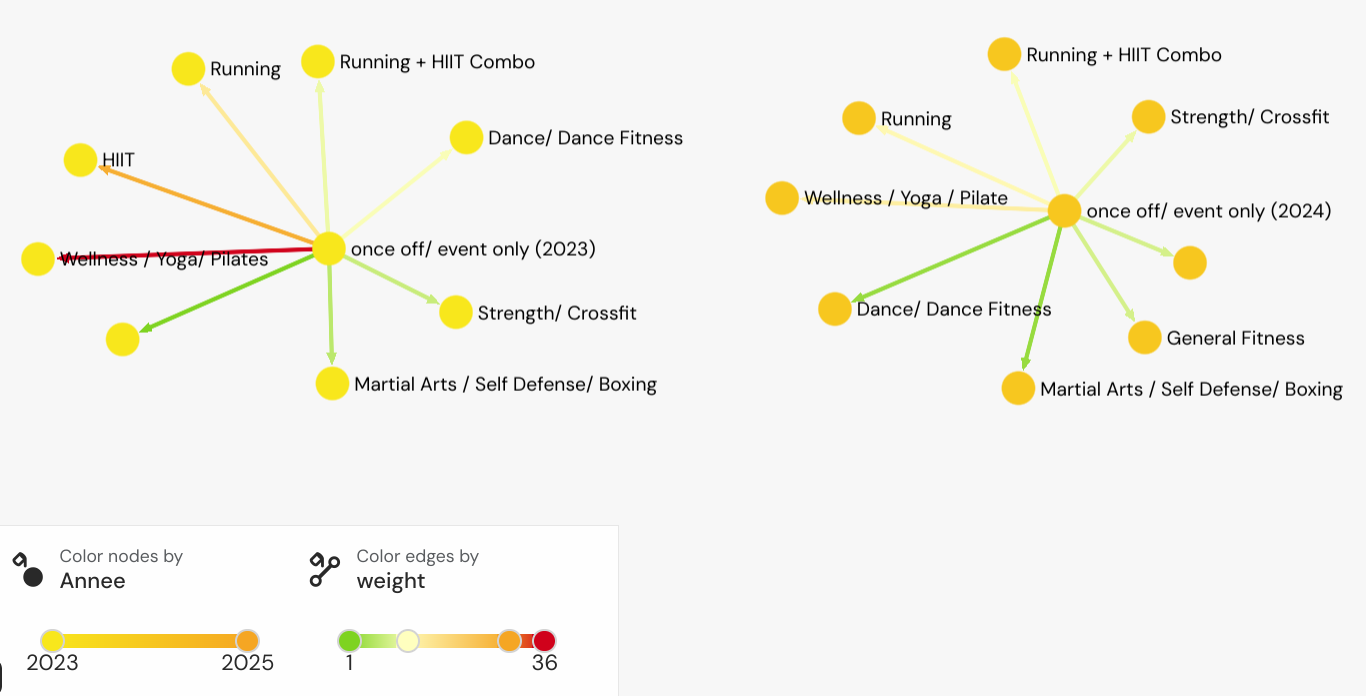

En 2023, tes événements ponctuels agissaient comme de puissants canaux d'acquisition, convertissant massivement les curieux en habitués (notamment Yoga et HIIT). En 2024, cette dynamique s'est essoufflée : les participants sont redirigés un peu partout, mais avec une intensité beaucoup plus faible. Le format "tremplin" fonctionne toujours pour la découverte, mais il ne transforme plus les essais en abonnements aussi efficacement qu'avant.